In [2]:
from metavision_ml.preprocessing import histo
from metavision_sdk_cv import RotateEventsAlgorithm
import numpy as np
from metavision_core.event_io import RawReader
from metavision_sdk_core import RoiFilterAlgorithm, FlipXAlgorithm
import matplotlib.pyplot as plt
import cv2
import time
from mplcursors import cursor
from math import pi

# D:\CZI_scope\code\data\imgs_and_plts\usaf_gr7_el1_2024-07-24T13-23-52.886.bmp
# D:\CZI_scope\code\preprocess\capillary\mixed\imgs\image_20240730_133544_109126.tif
file = input('Enter the path to the input file: ').strip()
dt = 1000000  # 1s
record = RawReader(file)
# record.seek_time(1e6) # skip first second
events = record.load_delta_t(dt)
# important! almost all preprocessing use relative time!
events['t'] -= events[0]['t']
height, width = record.get_size()
tbins = 2

# Rotate the image 90 degrees cc
# Mirror the image along the y axis
# Crop the image to the cmos sensor region

y1 = 100
y2 = 400
x1 = 265
x2 = 430
roi_algo = RoiFilterAlgorithm(x1, y1, x2, y2,  output_relative_coordinates=True)
rot_algo = RotateEventsAlgorithm(
    height_minus_one=height - 1, width_minus_one=width - 1, rotation=-pi/2)
flip_algo = FlipXAlgorithm(width_minus_one=width - 1)
roi_buffer = RoiFilterAlgorithm.get_empty_output_buffer()
rot_buffer = RotateEventsAlgorithm.get_empty_output_buffer()
flip_buffer = FlipXAlgorithm.get_empty_output_buffer()
#rot_algo.process_events(events, rot_buffer)
#flip_algo.process_events(rot_buffer, flip_buffer)
roi_algo.process_events(events, roi_buffer)
events = roi_buffer.numpy()

height = y2 - y1
width = x2 - x1
volume = np.zeros((tbins, 2, height, width), dtype=np.float32)
# Generate the histogram
histo(events, volume, dt)

ebis_img = volume.sum(axis=0)[1]  # sum over time
# normalize
ebis_img = ebis_img / ebis_img.max()
# clip negative values to 0
ebis_img[ebis_img < 0] = 0

# Read the image and plot it
# D:\CZI_scope\code\data\raw\recording_2024-07-24_13-23-56.raw
img_path = input("Image Path: ").strip()
cmos_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)

# Rotate the image 180 degrees
cmos_img = np.rot90(cmos_img, 3)
cmos_img = np.fliplr(cmos_img)
cmos_img = cmos_img / cmos_img.max()

# Crop the image to the DFA filter region
# x, y, width, height
cmos_roi = (250, 0, 950, 1440)
cmos_img = cmos_img[cmos_roi[1]:cmos_roi[3], cmos_roi[0]:cmos_roi[2]]

ebis_img = np.squeeze(ebis_img)
ebis_gray = cv2.cvtColor(
    ebis_img, cv2.COLOR_BGR2GRAY) if ebis_img.ndim == 3 else ebis_img
cmos_gray = cv2.cvtColor(
    cmos_img, cv2.COLOR_BGR2GRAY) if cmos_img.ndim == 3 else cmos_img

ebis_gray = (ebis_gray * 255).astype(np.uint8)
cmos_gray = (cmos_gray * 255).astype(np.uint8)


# D:\CZI_Scope\code\data\raw\recording_2024-03-19_17-43-40.raw (USAF Focus Chart)
# D:\CZI_Scope\code\data\raw\recording_2023-12-21_09-45-41_625_diffuser_no_motor_stationary.raw (Stationary bead)


date = time.strftime("%Y-%m-%d")
cv2.imwrite(
    rf'D:\CZI_scope\code\data\imgs_and_plts\usaf_gr7el1_{date}.png', ebis_img *
    255)
figure = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(ebis_gray, cmap='gray')
plt.subplot(122)
plt.imshow(cmos_gray, cmap='gray')
plt.tight_layout()
# make the grid lines more transparent
# plt.title('USAF Focus Chart 5s Average', fontsize=20)
cursor(hover=True)
plt.show()

ModuleNotFoundError: No module named 'mplcursors'

In [8]:
def map_cmos_to_ebis(cmos_x, cmos_y):
    magnification_cmos = 40
    magnification_ebis = 40 
    cmos_pitch = 3.45e-6
    ebis_pitch = 15e-6

    # Step 1: Convert CMOS coordinates to physical units (meters)
    cmos_x_m = cmos_x * cmos_pitch / magnification_cmos
    cmos_y_m = cmos_y * cmos_pitch / magnification_cmos

    # Step 2: Convert physical units to EBIS coordinates
    ebis_x = cmos_x_m * magnification_ebis / ebis_pitch
    ebis_y = cmos_y_m * magnification_ebis / ebis_pitch

    return ebis_x, ebis_y

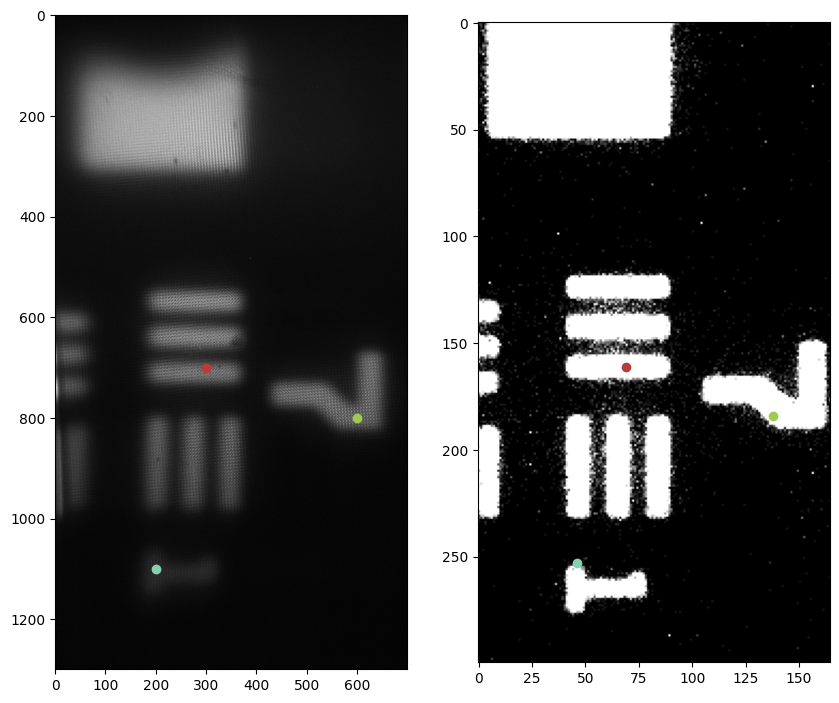

In [9]:
# Test the mapping function by plotting points on the CMOS and EBIS images and seeing how close they are
# to each other

cmos_gray_copy = cmos_gray.copy()
ebis_gray_copy = ebis_gray.copy()

# Trim the cmos y-axis from (0, 1440) to (0, 1200) to match the ebis image
cmos_gray_copy = cmos_gray_copy[:1300, :]


plt.figure(figsize=(10, 10))
plt.subplot(121)
ax_cmos = plt.imshow(cmos_gray_copy, cmap='gray')

plt.subplot(122)
ax_ebis = plt.imshow(ebis_gray, cmap='gray')

# CMOS coordinates
cmos_coords = [(200, 1100), (300, 700), (600, 800)]

# EBIS coordinates
for cmos_coord in cmos_coords:
    ebis_coord = map_cmos_to_ebis(*cmos_coord)
    plt.subplot(121)
    # Plot the CMOS coordinates with a random color and the EBIS coordinates with the same color
    color = np.random.rand(3)
    
    plt.scatter(*cmos_coord, color=color)
    plt.subplot(122)
    plt.scatter(*ebis_coord, color=color)

plt.show()

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to select points
def select_points(image, window_name):
    points = []
    while True:
        r = cv2.selectROI(window_name, image, fromCenter=False, showCrosshair=True)
        if r[2] == 0 or r[3] == 0:
            break
        x, y, w, h = r
        center = (x + w // 2, y + h // 2)
        points.append(center)
        cv2.circle(image, center, 5, (255, 0, 0), -1)
        cv2.imshow(window_name, image)
    cv2.destroyAllWindows()
    return np.array(points, dtype=np.float32)

# Select points in both images
print("Select points in the first image.")
points1 = select_points(cmos_img.copy(), "First Image")
print("Select points in the second image.")
points2 = select_points(ebis_img.copy(), "Second Image")

print(f"Points in the first image: {points1}")
print(f"Points in the second image: {points2}")

# Ensure that the number of points selected in both images is the same
assert points1.shape == points2.shape, "The number of points selected in both images must be the same."

# Compute the homography matrix
H, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

# Transform the first image to the second image's perspective
im1_transformed = cv2.warpPerspective(im1, H, (im2.shape[1], im2.shape[0]))

# Plot the images
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(cmos_img, cmap='gray')
plt.title('First Image')
plt.subplot(1, 3, 2)
plt.imshow(ebis_img, cmap='gray')
plt.title('Second Image')
plt.subplot(1, 3, 3)
plt.imshow(im1_transformed, cmap='gray')
plt.title('Transformed First Image')
plt.show()

# Calculate scale in micrometers per pixel
# Known size of an element in micrometers (example value)
usaf_element_size_um = 3.91

# Select two points that correspond to the size of the known element in both images
print("Select two points corresponding to the known element size in the first image.")
element_points1 = select_points(cmos_img.copy(), "First Image")
print("Select the corresponding points in the second image.")
element_points2 = select_points(ebis_img.copy(), "Second Image")

# Ensure two points are selected in both images
assert element_points1.shape[0] == 2 and element_points2.shape[0] == 2, "Two points must be selected in both images."

# Calculate distances in pixels
distance_pixels_cam1 = np.linalg.norm(element_points1[0] - element_points1[1])
distance_pixels_cam2 = np.linalg.norm(element_points2[0] - element_points2[1])

# Calculate scale in micrometers per pixel
scale_cam1 = usaf_element_size_um / distance_pixels_cam1
scale_cam2 = usaf_element_size_um / distance_pixels_cam2

print(f"Scale for Camera 1: {scale_cam1} um/pixel")
print(f"Scale for Camera 2: {scale_cam2} um/pixel")

# Example point in the first image (in pixels)
point_cam1 = np.array([150, 200], dtype=np.float32)

# Transform the point to the second image's perspective
point_cam1_homogeneous = np.array([point_cam1[0], point_cam1[1], 1], dtype=np.float32)
point_cam2_homogeneous = np.dot(H, point_cam1_homogeneous)
point_cam2_homogeneous /= point_cam2_homogeneous[2]

# Convert to micrometers
point_cam1_um = point_cam1 * scale_cam1
point_cam2_um = point_cam2_homogeneous[:2] * scale_cam2

print(f"Point in Camera 1 (um): {point_cam1_um}")
print(f"Point in Camera 2 (um): {point_cam2_um}")


Select points in the first image.


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

magnification = 34
# Calculate the intensity profile along the horizontal axis
starting_line = (32, 47, 42, 47)
lines = [starting_line]
spacing = 3 # pixels
for i in range(1, 3):
    y = starting_line[1] - (i * spacing)
    lines.append((32, y, 42, y)) # 10 lines
# plot a line on the image
plt.imshow(ebis_img)
plt.tight_layout()
#include axes for better orientation
plt.gca().invert_yaxis()
# place grids on every 50 pixels
#plt.xticks(np.arange(0, width, 25))
# rotate x-axis labels
#plt.xticks(rotation=45)
# show axes
#plt.yticks(np.arange(0, height, 25))
# make the grid lines more transparent
#plt.grid(alpha=0.3)
# plot the line
for line in lines:
    l, = plt.plot([line[0], line[2]], [line[1], line[3]], 'r')
    l.set_linewidth(0.2)
# set the line width
plt.title('Stationary Bead 5s Average', fontsize=20)

# Add a white box to the plot
plt.gca().add_patch(plt.Rectangle((10, 80), 43, 15, fill=True, edgecolor='black', linewidth=0.5, facecolor='white', zorder=99))
# add a drop shadow to the box
plt.gca().add_patch(plt.Rectangle((8, 78), 43, 15, fill=True, edgecolor='black', linewidth=0, facecolor='black', alpha=0.2))
# Place text in the box
plt.text(12, 90, 'Bead Size: 1µm', fontsize=10, color='black', zorder=100)
plt.text(12, 85, 'Measured Size: 1.54µm', fontsize=10, color='black', zorder=100)

# Add a scale bar
um_to_px = magnification/15
plt.plot([80, 80 + 1 * um_to_px], [10, 10], 'w', linewidth=2)
# Add a scale bar label
plt.text(80 + 0.5 * um_to_px, 5, '1µm', color='white', fontsize=10, ha='center')

# calculate the intensity profile along the lines
scans = []
for line in lines:
    x1, y1, x2, y2 = line
    
    if x1 == x2:
        # Vertical line
        line_scan = ebis_img[min(y1, y2):max(y1, y2), x1]
    elif y1 == y2:
        # Horizontal line
        line_scan = ebis_img[y1, min(x1, x2):max(x1, x2)]
    else:
        # If lines are neither strictly horizontal nor vertical, handle as needed
        line_scan = ebis_img[min(y1, y2):max(y1, y2), min(x1, x2):max(x1, x2)]
    
    scans.append(line_scan)


intensity = np.mean(scans, axis=0)
intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())
# interpolate the intensity profile as spline
x = np.arange(len(intensity))
f = interp1d(x, intensity, kind='cubic')
x_new = np.linspace(0, len(intensity) - 1, int(1e3))
# normalize the intensity profile
intensity_interp = f(x_new)
# plot the intensity profile
plt.figure()
plt.plot(x_new, intensity_interp, label='Spline Interpolated') # plot the interpolated intensity profile
dot_size = 15 # Adjust this value to change the dot size
plt.scatter(x, intensity, color='red', s=dot_size, zorder=99, label='Original')
plt.title('Intensity Profile along the Horizontal Axis')
plt.legend()
plt.show()

# calculate the derivative of the interpolated intensity profile
derivative = np.gradient(intensity_interp)
# find the peaks in the derivative
peaks, _ = find_peaks(derivative)
# find the 3 highest peaks in the derivative
peaks = peaks[np.argsort(derivative[peaks])[-3:]]
# find the corresponding valleys
valleys = np.array([np.argmin(derivative[p:]) + p for p in peaks])
# find the y values of the peaks and valleys
peaks_x = x_new[peaks]
valleys_x = x_new[valleys]
# calculate the distances between the peak and valley pairs
distances = np.abs(peaks_x - valleys_x)
# calculate the resolution
resolution = 15 * distances / magnification
# mean resolution
mean_resolution = resolution.mean()
print(f'Mean resolution: {mean_resolution:.2f} um')

derivative = np.gradient(intensity)
peaks, _ = find_peaks(derivative)
peaks = peaks[np.argsort(derivative[peaks])[-3:]]
valleys = np.array([np.argmin(derivative[p:]) + p for p in peaks])
peaks_x = x[peaks]
valleys_x = x[valleys]
distances = np.abs(peaks_x - valleys_x)
resolution = 15 * distances / magnification
mean_resolution = resolution.mean()
print(f'Mean resolution: {mean_resolution:.2f} um')

mean_distance = distances.mean()
mean_distance


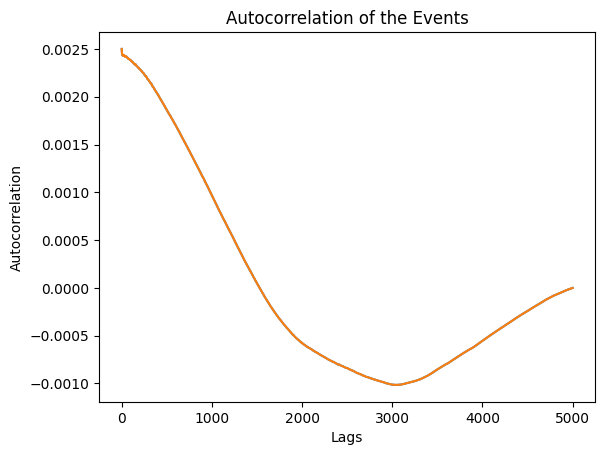

In [13]:
from metavision_ml.preprocessing import histo
from metavision_core.event_io import RawReader
from scipy.signal import correlate
import numpy as np
import holoviews as hv
import datashader as ds
import pandas as pd
from holoviews.operation.datashader import datashade
import matplotlib.pyplot as plt

file = input('Enter the path to the input file: ').strip()
reader = RawReader(file)
dt = int(1e6) # 1s
events = reader.load_delta_t(dt)
height, width = reader.get_size()
tsize = 200 # 200us
tbins = int(1e6 // tsize)
volume = np.zeros((tbins, 2, int(height//4), int(width//4)), dtype=np.float32)
histo(events, volume, dt, 2)
volume = volume.sum(axis=1) # sum over polarities
volume = volume.reshape(tbins, -1) # flatten the spatial dimensions
volume = volume.mean(axis=1) # average over space
evts_demeaned = volume - volume.mean(axis=0) # demean the events
autocorr = correlate(evts_demeaned, evts_demeaned, mode='full')
autocorr = autocorr[len(autocorr)//2:] # keep only the positive lags
# Prepare data for Holoviews and Datashader
lags = np.arange(len(autocorr))

plot_width = 800
plot_height = 400

# Create a Holoviews Curve element
# Use Datashader to render the curve efficiently

# Display the plot
plt.plot(lags, autocorr)
plt.title('Autocorrelation of the Events')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()
# free memory
del autocorr, volume, evts_demeaned